# Import libraries

In [49]:
# Misc
import collections

# Data analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# Machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Loading and Cleaning data

In [50]:
# Review dataframe
insurance = pd.read_csv('insurance_data.csv', sep=';')
print(insurance.shape)
insurance.head(5)

(5500, 15)


,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,NaN,12.0,Yes,"19,65","451,55",Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,3,1.0,Yes,"84,65","3541,35",N
2,3,F,0.0,Yes,No,72,Yes,No,No,NaN,12.0,No,"19,4","1496,45",Y
3,4,F,0.0,Yes,Yes,13,Yes,No,No,NaN,12.0,No,"19,55","265,3",Y
4,5,F,0.0,No,No,37,Yes,Yes,Class A,"3,4",1.0,No,"100,3","3541,4",Y


In [51]:
# Check NA fields
insurance.isna().sum().sort_values(ascending=False)

healthRiders                1982
premiumFrequency             114
gender                       113
is45OrOlder                   96
insuree#                       0
isMarried                      0
hasKids                        0
insuredMonths                  0
termLifeInsurance              0
multipleTermLifePolicies       0
healthInsurance                0
eStatements                    0
monthlyPremium                 0
totalPremium                   0
renewal                        0
dtype: int64

In [52]:
# Value counts of all fields with NA
df = insurance.copy()
for i in df.columns[df.isnull().any()]:
    print(df[i].value_counts())

M    2719
F    2668
Name: gender, dtype: int64
0.0    4525
1.0     879
Name: is45OrOlder, dtype: int64
3,4        474
2,3,4      434
1,2,3,4    374
2          304
1          277
1,2        247
3          238
4          232
1,3,4      228
2,3        139
2,4        133
1,2,4      131
1,2,3      126
1,4         95
1,3         86
Name: healthRiders, dtype: int64
1.0     2959
12.0    1308
3.0     1119
Name: premiumFrequency, dtype: int64


In [53]:
### Dealing with NA Values
# Gender: Remove all NAs as there is no way for us to fill an arbitrary gender
df = df[df.gender.notna()]

# is45OrOlder: Remove all NAs as there is no way for us to fill an arbitrary age
df = df[df.is45OrOlder.notna()]

# healthRiders: change all values to 0 as there may be people with policies without riders
df.healthRiders.loc[df.healthRiders.isna()] = 0

# premiumFrequency: change all values to 0 as premium can be fully paid
df.premiumFrequency.loc[df.premiumFrequency.isna()] = 0

df.head(2)

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal
0,1,F,0.0,Yes,Yes,23,Yes,No,No,0,12.0,Yes,"19,65","451,55",Y
1,2,F,1.0,No,No,42,Yes,Yes,Class A,3,1.0,Yes,"84,65","3541,35",N


# Visualisations: Cross sections of data

Average number of riders per customer: 1.3879440665154952


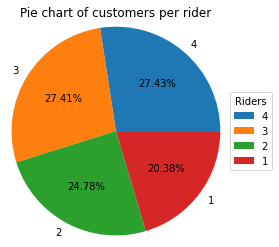

The pie chart shows that the most popular riders among customers are 3 and 4.


In [103]:
### Q1. 

## Average number of riders per customer
def count_riders(x):
    if isinstance(x, str) == True:
        return x.count(',')+1
    else:
        if x == 0:
            return 0
        return 1
df['count_riders'] = df.healthRiders.apply(lambda x: count_riders(x))
print('Average number of riders per customer: ' + str(df.count_riders.mean()))

## Most popular riders

rider_split_ = []

for i in range(df.count_riders.max()):
    rider_split_.append('rider_split_' +str(i))

df[rider_split_] = df.healthRiders.str.split(',', expand = True) # create a split for each unique rider
split_w_age = ['is45OrOlder'] + rider_split_ 

split_df = df[split_w_age] # add in age for filter
riders_df =  pd.melt(split_df, id_vars = ['is45OrOlder'], value_vars = rider_split_) # create melted value table with ages
riders_df['Age Group'] = riders_df.is45OrOlder.apply(lambda x: 'Older' if x == 1 else 'Younger') # Visualising data

riders, cust_per_rider = riders_df.value.value_counts().keys().tolist(), riders_df.value.value_counts().tolist()

plt.pie(cust_per_rider, labels = riders, autopct= '%1.2f%%', radius = 1.2)
plt.title('Pie chart of customers per rider')

plt.legend(
          title="Riders",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()
print('The pie chart shows that the most popular riders among customers are 3 and 4.')

The histplot grouping the customers by age shows that the most popular riders among Older people are also 3 and 4.


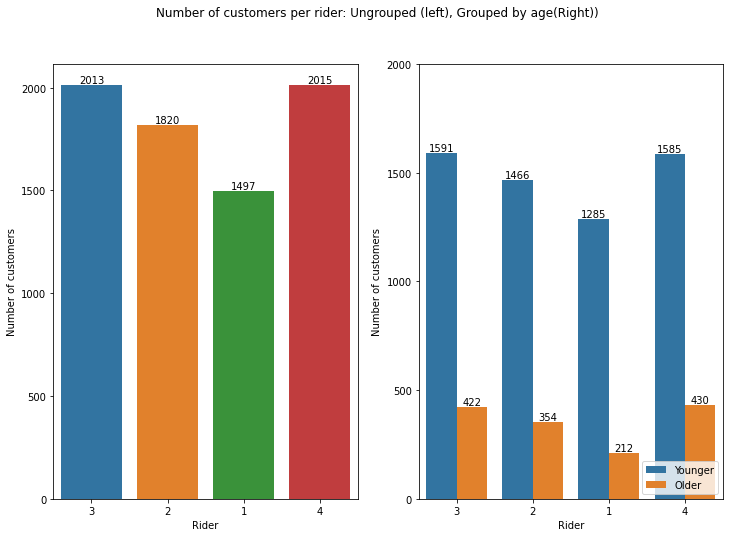

In [104]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,8))

sns.countplot(x = riders_df['value'], dodge = False, ax = ax1)
sns.countplot(x = riders_df['value'], hue = riders_df['Age Group'], dodge = True, ax = ax2)
ax1.bar_label(ax1.containers[0])
ax2.bar_label(ax2.containers[0])
ax2.bar_label(ax2.containers[1])

ax1.set_yticks([0,500,1000,1500,2000])
ax2.set_yticks([0,500,1000,1500,2000])
plt.legend(loc= 'lower right')
plt.suptitle('Number of customers per rider: Ungrouped (left), Grouped by age(Right))')
ax1.set_xlabel('Rider')
ax1.set_ylabel('Number of customers')
ax2.set_xlabel('Rider')
ax2.set_ylabel('Number of customers')

print('The histplot grouping the customers by age shows that the most popular riders among Older people are also 3 and 4.')

# Data Pre-processing for predictions

In [56]:
# Change all yes no into 0-1
df = df.replace('Yes', 1).replace('No', 0)

df.head(5)

,insuree#,gender,is45OrOlder,isMarried,hasKids,insuredMonths,termLifeInsurance,multipleTermLifePolicies,healthInsurance,healthRiders,premiumFrequency,eStatements,monthlyPremium,totalPremium,renewal,count_riders,rider_split_0,rider_split_1,rider_split_2,rider_split_3
0,1,F,0.0,1,1,23,1,0,0,0,12.0,1,"19,65","451,55",Y,0,NaN,NaN,NaN,NaN
1,2,F,1.0,0,0,42,1,1,Class A,3,1.0,1,"84,65","3541,35",N,1,3,None,None,None
2,3,F,0.0,1,0,72,1,0,0,0,12.0,0,"19,4","1496,45",Y,0,NaN,NaN,NaN,NaN
3,4,F,0.0,1,1,13,1,0,0,0,12.0,0,"19,55","265,3",Y,0,NaN,NaN,NaN,NaN
4,5,F,0.0,0,0,37,1,1,Class A,"3,4",1.0,0,"100,3","3541,4",Y,2,3,4,None,None


In [57]:
non_numeric_fields = df.select_dtypes(exclude = ['int64', 'float64']).columns.tolist()
print(non_numeric_fields)

['gender', 'multipleTermLifePolicies', 'healthInsurance', 'healthRiders', 'monthlyPremium', 'totalPremium', 'renewal', 'rider_split_0', 'rider_split_1', 'rider_split_2', 'rider_split_3']
